In [1]:
import numpy as np
import numba
from numba import jit
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('bmh')
import plotly.graph_objects as go
from IPython.display import HTML
from scipy.linalg import eigh_tridiagonal

$$ B(r) = -B_1 r e_r + (B_0 + B_1 z) e_z $$

$$ A = \frac{r}{2} (B_0 + B_1 z) e_\theta $$

In [2]:
B0 = 1
B1 = 1
x = np.linspace(-20, 20, 5)
y = np.linspace(-20, 20, 5)
z = np.linspace(-20, 20, 5)
xv, yv, zv = np.meshgrid(x, y, z)
Bx = -B1*xv
By = -B1*yv
Bz = B0 + B1*zv

In [3]:
data = go.Cone(
    x=xv.ravel(), y=yv.ravel(), z=zv.ravel(),
    u=Bx.ravel(), v=By.ravel(), w=Bz.ravel(),
    colorscale='Inferno', colorbar=dict(title='$x^2$'),
    sizemode="absolute", sizeref=20
)

layout = go.Layout(
    title=r'Plot title',
    scene=dict(
        xaxis_title = r'x',
        yaxis_title = r'y',
        zaxis_title = r'z',
        aspectratio = dict(x=1, y=1, z=1),
        camera_eye = dict(x=1.2, y=1.2, z=1.2)
    )
)

fig = go.Figure(data = data, layout = layout)

fig.write_html("Example2.html")
fig.show()

The Schrodinger Equation reads

$$
i \frac{\partial \psi}{\partial t} = -\left( \frac{\partial ^2 \psi}{\partial r^2} + \frac{1}{r} \frac{\partial \psi}{\partial r} + \frac{\partial ^2\psi}{\partial z^2} \right) + s(b_0 + b_1 z)\psi
$$

We make the transformations
* $ r \rightarrow \lambda r , \quad z \rightarrow \lambda z, \quad, t \rightarrow \tau t $
* $b_0 = \frac{2m\mu_B \lambda^2 B_0}{\hbar^2}$
* $b_1 = \frac{2m\mu_B \lambda^3 B_1}{\hbar^2}$
* $\tau = \frac{2m\lambda^2}{\hbar}$
* $\sigma_z \rightarrow s=\pm_1$

Choose a discrete grid with spacing $\Delta r$ and $\Delta z$ and $\Delta t$ and let $\psi_{i, n}^{m} = \psi(i\Delta r, n\Delta z, m\Delta t)$

$$
i \frac{\psi_{i,n}^{m+1} - \psi_{i, n}^m}{\Delta t} = - \frac{\psi_{i+1, n}^m - 2\psi_{i, n}^m + \psi_{i-1, n}^m}{\Delta r^2} -\frac{1}{r}\frac{\psi_{i+1, n}^m - \psi_{i, n}^m}{\Delta r} -\frac{\psi_{i, n+1}^m - 2\psi_{i, n}^m + \psi_{i, n-1}^m}{\Delta z^2} + s(b_0 + b_1 z) \psi_{i, n}^m
$$

Rearrange the equation

$$
\psi_{i,n}^{m+1} = \psi_{i,n}^m + \frac{i}{2}\Delta t\left(\frac{\psi_{i+1, n}^m - 2\psi_{i, n}^m + \psi_{i-1, n}^m}{\Delta r^2} + \frac{1}{r}\frac{\psi_{i+1, n}^m - \psi_{i, n}^m}{\Delta r} + \frac{\psi_{i, n+1}^m - 2\psi_{i, n}^m + \psi_{i, n-1}^m}{\Delta z^2} \right) - i\Delta t s(b_0 + b_1 z) \psi_{i, n}^m
$$




Define all parameters of interest.

In [294]:
Nr = 21
Nz = 21
Nt = 3600000
times_snapshot = 3600
f = int(Nt/times_snapshot)
dr = 1/(Nr-1)
dz = 1/(Nz-1)
dt = 1e-7
z = np.linspace(-4, 4, Nz)
r = np.linspace(0, 0.03, Nr)
b0 = 50
b1 = 10
Z, R = np.meshgrid(z, r)
psi0 = np.exp(-R**2/(4*(0.005**2))) * np.exp(-Z**2/4)

In [295]:
psi = np.zeros([times_snapshot, Nr, Nz])
psi[0] = psi0

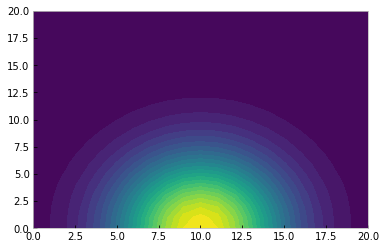

In [296]:
plt.contourf(psi0, 30)
plt.grid()

In [287]:
@numba.jit("c16[:, :, :](c16[:, :, :], f8)", nopython=True, nogil=True)
def compute_psi(psi, s):
  cs = psi[0].copy()  # current state
  length = len(cs[0])
  cf = 0  # current frame
  for t in range(1, Nt):
    ns = cs.copy()  # new state
    for i in range(1, length-1):
      for n in range(1, length-1):
        ns[i][n] = cs[i][n] + 1j/2 * dt * ((cs[i+1][n] - 2*cs[i][n] + cs[i-1][n])/dr**2 + (cs[i+1][n] - cs[i][n])/(2*r[i]*dr) + (cs[i][n+1] - 2*cs[i][n] + cs[i][n-1])/dz**2) - 1j*dt*s*(b0 + b1*z[n])*cs[i][n]

    normal = np.sum(np.absolute(ns)**2)*dr*dz
    for i in range(1, Nr-1):
      for n in range(1, Nz-1):
        ns[i][n] = ns[i][n] / normal
    
    cs = ns.copy()
    if t%f==0:
      cf = cf + 1
      psi[cf] = cs
    
  return psi

In [288]:
psi_p = compute_psi(psi.astype(complex), 1)
psi_n = compute_psi(psi.astype(complex), -1)

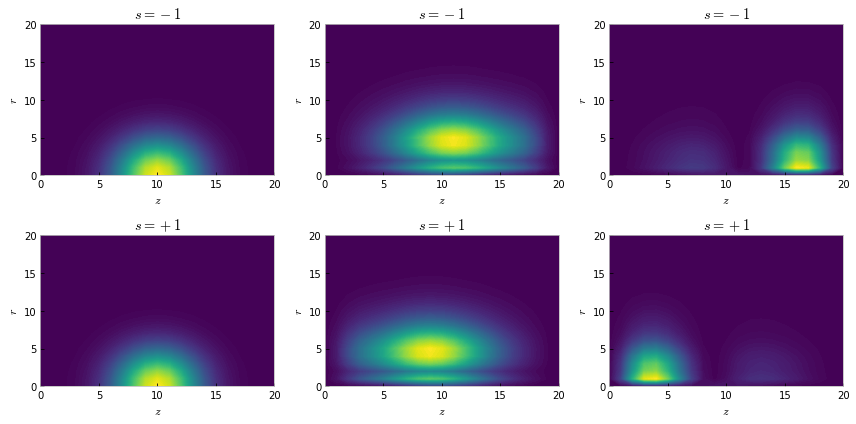

In [302]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
ax = axes[0][0]
ax.contourf(np.absolute(psi_n[0])**2, 100)
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$r$')
ax.set_title(r'$s=-1$')
ax.grid()

ax = axes[1][0]
ax.contourf(np.absolute(psi_p[0])**2, 100)
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$r$')
ax.set_title(r'$s=+1$')
ax.grid()

ax = axes[0][1]
ax.contourf(np.absolute(psi_n[360])**2, 100)
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$r$')
ax.set_title(r'$s=-1$')
ax.grid()

ax = axes[1][1]
ax.contourf(np.absolute(psi_p[360])**2, 100)
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$r$')
ax.set_title(r'$s=+1$')
ax.grid()

ax = axes[0][2]
ax.contourf(np.absolute(psi_n[3599])**2, 100)
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$r$')
ax.set_title(r'$s=-1$')
ax.grid()

ax = axes[1][2]
ax.contourf(np.absolute(psi_p[3599])**2, 100)
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$r$')
ax.set_title(r'$s=+1$')
ax.grid()

plt.tight_layout()
plt.show()

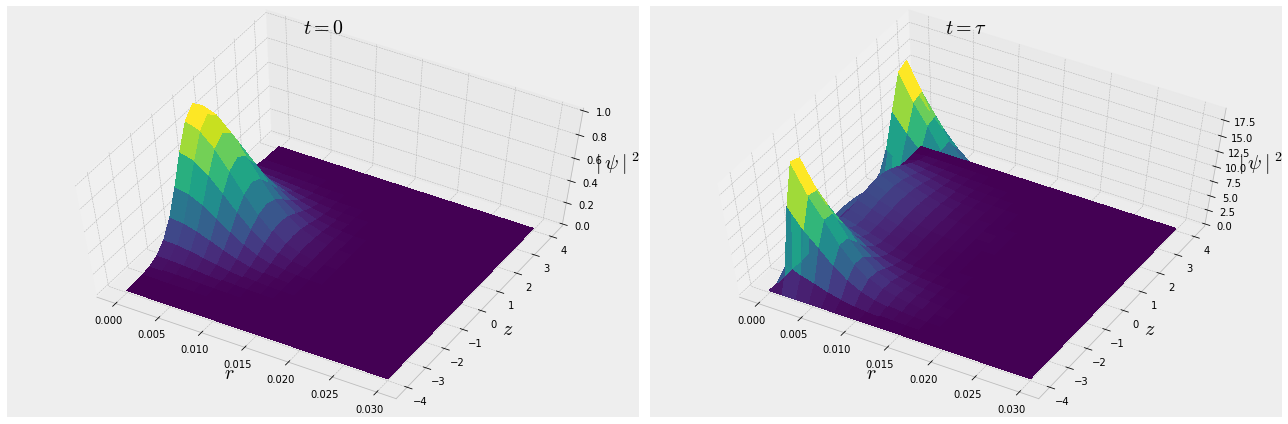

In [300]:
# 3D Plot
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1, 2, 1, projection='3d', elev=60)
t = 0
ax.plot_surface(R, Z, np.absolute(psi_p[t])**2, cmap='viridis', rstride=1, cstride=1, linewidth=0, antialiased=False)
ax.plot_surface(R, Z, np.absolute(psi_n[t])**2, cmap='viridis', rstride=1, cstride=1, linewidth=0, antialiased=False)
ax.set_xlabel('$r$', fontsize=20)
ax.set_ylabel('$z$', fontsize=20)
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel(r'$\mid \psi\mid ^2$', fontsize=20, rotation=0)
ax.set_title(f'$t={t}$', fontsize=20)

ax = fig.add_subplot(1, 2, 2, projection='3d', elev=60)
t = 1599
ax.plot_surface(R, Z, np.absolute(psi_p[t])**2, cmap='viridis', rstride=1, cstride=1, linewidth=0, antialiased=False)
ax.plot_surface(R, Z, np.absolute(psi_n[t])**2, cmap='viridis', rstride=1, cstride=1, linewidth=0, antialiased=False)
ax.set_xlabel('$r$', fontsize=20)
ax.set_ylabel('$z$', fontsize=20)
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel(r'$\mid \psi\mid ^2$', fontsize=20, rotation=0)
ax.set_title(r'$t=\tau$', fontsize=20)

fig.tight_layout()

In [291]:
from matplotlib import animation
from matplotlib.animation import PillowWriter

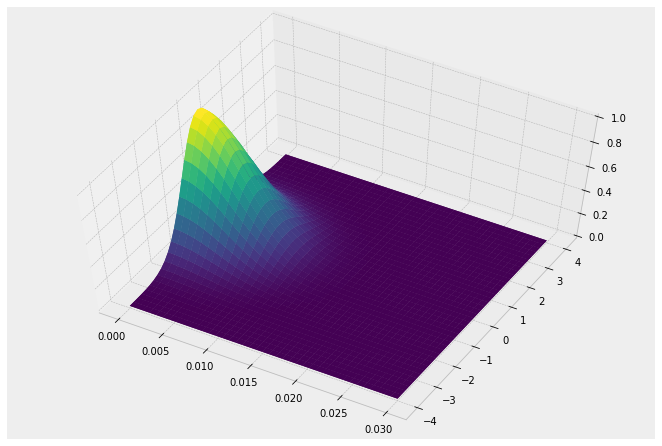

In [292]:
# 3D Plot
fig = plt.figure(figsize=(9,6))
ax = Axes3D(fig, elev=60)

ax.set_xlabel('$r$', fontsize=20)
ax.set_ylabel('$z$', fontsize=20)
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel(r'$\mid \psi\mid ^2$', fontsize=20, rotation=0)

def animate(i):
  ax.clear()
  ax.plot_surface(R, Z, np.absolute(psi_p[10*i])**2, cmap='viridis')
  ax.plot_surface(R, Z, np.absolute(psi_n[10*i])**2, cmap='viridis')

ani = animation.FuncAnimation(fig, animate, frames=359, interval=50)
ani.save('ani.gif', writer='pillow', fps=30)

In [303]:
!ls

ani.gif  psi_n.npy  psi_p.npy  sample_data
